# Introduction

This lab demonstrates how to use Scikit-Learn to perform outlier detection on classical anomaly detection datasets using the local outlier factor (LOF) and isolation forest (IForest) algorithms. The performance of the algorithms is assessed in an outlier detection context, and ROC curves are used to plot the results.

# Data Preprocessing

The first step is to preprocess the dataset. In this example, we use real-world datasets available in Scikit-Learn's **datasets** module. The sample size of some datasets is reduced to speed up computation. After the data preprocessing, the datasets' targets will have two classes, 0 representing inliers and 1 representing outliers. The **preprocess_dataset** function returns data and target.

In [1]:
import numpy as np
from sklearn.datasets import fetch_kddcup99, fetch_covtype, fetch_openml
from sklearn.preprocessing import LabelBinarizer
import pandas as pd

rng = np.random.RandomState(42)

def preprocess_dataset(dataset_name):
    # loading and vectorization
    print(f"Loading {dataset_name} data")
    if dataset_name in ["http", "smtp", "SA", "SF"]:
        dataset = fetch_kddcup99(subset=dataset_name, percent10=True, random_state=rng)
        X = dataset.data
        y = dataset.target
        lb = LabelBinarizer()

        if dataset_name == "SF":
            idx = rng.choice(X.shape[0], int(X.shape[0] * 0.1), replace=False)
            X = X[idx]  # reduce the sample size
            y = y[idx]
            x1 = lb.fit_transform(X[:, 1].astype(str))
            X = np.c_[X[:, :1], x1, X[:, 2:]]
        elif dataset_name == "SA":
            idx = rng.choice(X.shape[0], int(X.shape[0] * 0.1), replace=False)
            X = X[idx]  # reduce the sample size
            y = y[idx]
            x1 = lb.fit_transform(X[:, 1].astype(str))
            x2 = lb.fit_transform(X[:, 2].astype(str))
            x3 = lb.fit_transform(X[:, 3].astype(str))
            X = np.c_[X[:, :1], x1, x2, x3, X[:, 4:]]
        y = (y != b"normal.").astype(int)
    if dataset_name == "forestcover":
        dataset = fetch_covtype()
        X = dataset.data
        y = dataset.target
        idx = rng.choice(X.shape[0], int(X.shape[0] * 0.1), replace=False)
        X = X[idx]  # reduce the sample size
        y = y[idx]

        # inliers are those with attribute 2
        # outliers are those with attribute 4
        s = (y == 2) + (y == 4)
        X = X[s, :]
        y = y[s]
        y = (y != 2).astype(int)
    if dataset_name in ["glass", "wdbc", "cardiotocography"]:
        dataset = fetch_openml(
            name=dataset_name, version=1, as_frame=False, parser="pandas"
        )
        X = dataset.data
        y = dataset.target

        if dataset_name == "glass":
            s = y == "tableware"
            y = s.astype(int)
        if dataset_name == "wdbc":
            s = y == "2"
            y = s.astype(int)
            X_mal, y_mal = X[s], y[s]
            X_ben, y_ben = X[~s], y[~s]

            # downsampled to 39 points (9.8% outliers)
            idx = rng.choice(y_mal.shape[0], 39, replace=False)
            X_mal2 = X_mal[idx]
            y_mal2 = y_mal[idx]
            X = np.concatenate((X_ben, X_mal2), axis=0)
            y = np.concatenate((y_ben, y_mal2), axis=0)
        if dataset_name == "cardiotocography":
            s = y == "3"
            y = s.astype(int)
    # 0 represents inliers, and 1 represents outliers
    y = pd.Series(y, dtype="category")
    return (X, y)

# Outlier Prediction Function

The next step is to define an outlier prediction function. In this example, we use the **LocalOutlierFactor** and **IsolationForest** algorithms. The **compute_prediction** function returns average outlier score of X.

In [2]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

def compute_prediction(X, model_name):
    print(f"Computing {model_name} prediction...")
    if model_name == "LOF":
        clf = LocalOutlierFactor(n_neighbors=20, contamination="auto")
        clf.fit(X)
        y_pred = clf.negative_outlier_factor_
    if model_name == "IForest":
        clf = IsolationForest(random_state=rng, contamination="auto")
        y_pred = clf.fit(X).decision_function(X)
    return y_pred

# Plot and Interpret Results

The final step is to plot and interpret the results. The algorithm performance relates to how good the true positive rate (TPR) is at low value of the false positive rate (FPR). The best algorithms have the curve on the top-left of the plot and the area under curve (AUC) close to 1. The diagonal dashed line represents a random classification of outliers and inliers.

Loading http data
Computing LOF prediction...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


Computing IForest prediction...
Loading smtp data
Computing LOF prediction...
Computing IForest prediction...
Loading SA data
Computing LOF prediction...
Computing IForest prediction...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


Loading SF data
Computing LOF prediction...
Computing IForest prediction...
Loading forestcover data


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


Computing LOF prediction...
Computing IForest prediction...
Loading glass data
Computing LOF prediction...
Computing IForest prediction...
Loading wdbc data
Computing LOF prediction...
Computing IForest prediction...
Loading cardiotocography data
Computing LOF prediction...
Computing IForest prediction...


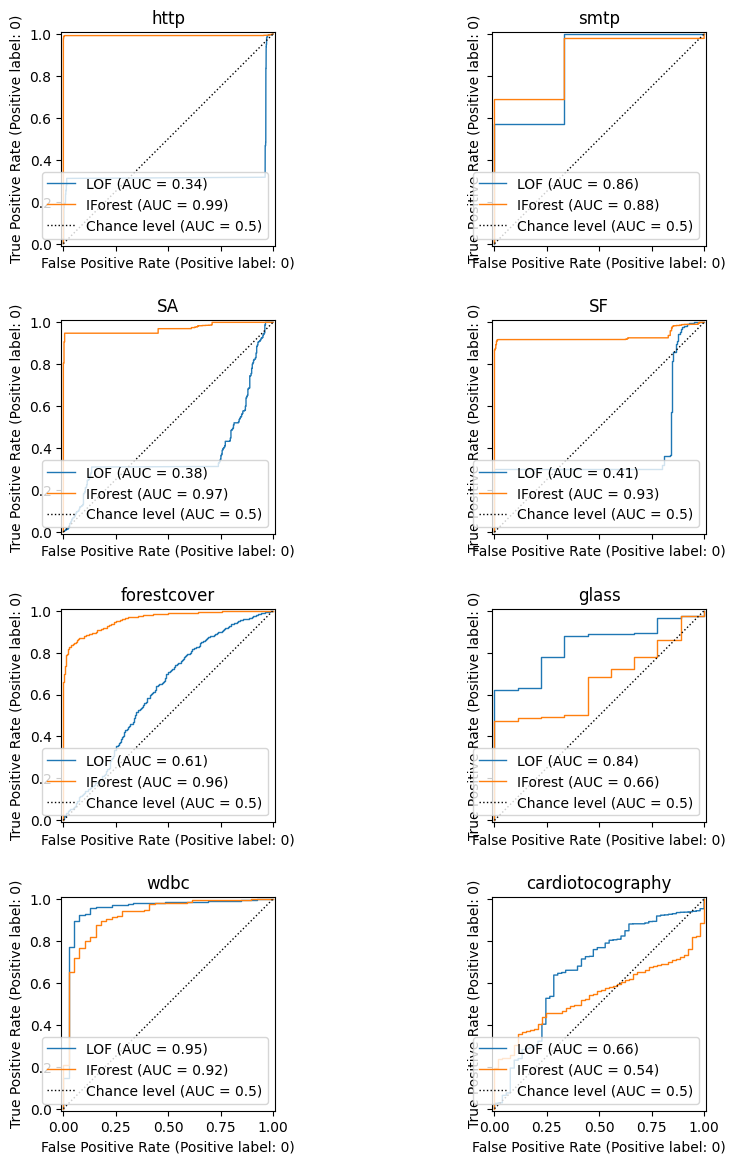

In [3]:
import math
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

datasets_name = [
    "http",
    "smtp",
    "SA",
    "SF",
    "forestcover",
    "glass",
    "wdbc",
    "cardiotocography",
]

models_name = [
    "LOF",
    "IForest",
]

# plotting parameters
cols = 2
linewidth = 1
pos_label = 0  # mean 0 belongs to positive class
rows = math.ceil(len(datasets_name) / cols)

fig, axs = plt.subplots(rows, cols, figsize=(10, rows * 3), sharex=True, sharey=True)

for i, dataset_name in enumerate(datasets_name):
    (X, y) = preprocess_dataset(dataset_name=dataset_name)

    for model_idx, model_name in enumerate(models_name):
        y_pred = compute_prediction(X, model_name=model_name)
        display = RocCurveDisplay.from_predictions(
            y,
            y_pred,
            pos_label=pos_label,
            name=model_name,
            linewidth=linewidth,
            ax=axs[i // cols, i % cols],
            plot_chance_level=(model_idx == len(models_name) - 1),
            chance_level_kw={
                "linewidth": linewidth,
                "linestyle": ":",
            },
        )
    axs[i // cols, i % cols].set_title(dataset_name)
plt.tight_layout(pad=2.0)  # spacing between subplots
plt.show()

# Summary

This lab demonstrated how to use Scikit-Learn to perform outlier detection on classical anomaly detection datasets using the local outlier factor (LOF) and isolation forest (IForest) algorithms. The performance of the algorithms was assessed in an outlier detection context, and ROC curves were used to plot the results.